## 1. Set Kaggle API information and dataset local directories

In [1]:
# Set Kaggle API - Username / Key to download the images
import os
os.environ['KAGGLE_USERNAME'] = "franconicolsmerenda"
os.environ['KAGGLE_KEY'] = "edcd91fb1521ad3ee181a8b093795eab"
os.environ['DATASET_FOLDER'] = "/home/millenium-falcon/SoftwareProjects/ai-art-casa/.datasets" #change this directory to the one where the data is
os.environ['ART_STYLE'] = "realism"

# DATASET Folders where to reach the images
os.environ['TRAIN_DATASET_ART_STYLE'] = f"{os.environ['DATASET_FOLDER']}/Real_AI_SD_LD_Dataset/train"
os.environ['TEST_DATASET_ART_STYLE'] = f"{os.environ['DATASET_FOLDER']}/Real_AI_SD_LD_Dataset/test"

# Data Folder to be consumed by the model!
os.environ['TOP_DIR']=f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}"
os.environ['TRAIN_ART_STYLE_DATA'] = f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}/train"
os.environ['VALID_ART_STYLE_DATA'] = f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}/valid"

## 2. Download dataset if it is not stored locally

In [2]:
# Download Datasets if Needed
import os

# Define the folder path
folder_path = f"{os.environ['DATASET_FOLDER']}"

# Check if the folder exists and download it if it doesnt
if not os.path.exists(f"{folder_path}/Real_AI_SD_LD_Dataset"):
    # Install kaggle package
    !pip install -q kaggle
    # Download the dataset from Kaggle
    !kaggle datasets download -d ravidussilva/real-ai-art -p $folder_path --unzip
else:
    print("Folder already exists.")

Folder already exists.


## 3. Copy and divide images into directories separating them by the requested Art Style

In [3]:
# Set Art Style Dataset

# 1. Make clean data
!rm -rf $TRAIN_ART_STYLE_DATA
!rm -rf $VALID_ART_STYLE_DATA

# 2. Create folders of the current art style training/validation data
!mkdir -p $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!mkdir -p $TRAIN_ART_STYLE_DATA/$ART_STYLE

!mkdir -p $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!mkdir -p $VALID_ART_STYLE_DATA/$ART_STYLE

# 3. Load with data from DATASET
!cp -r $TRAIN_DATASET_ART_STYLE/AI_LD_$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TRAIN_DATASET_ART_STYLE/AI_SD_$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TRAIN_DATASET_ART_STYLE/$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/$ART_STYLE

!cp -r $TEST_DATASET_ART_STYLE/AI_LD_$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TEST_DATASET_ART_STYLE/AI_SD_$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TEST_DATASET_ART_STYLE/$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/$ART_STYLE

## 4. Import the needed dependencies for the model and data visualization

In [4]:
#Import Dependencies
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pandas as pd
import seaborn as sns

2024-07-18 10:56:58.470865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 10:56:58.947179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 5. Set dataset parameters and details

In [5]:
# Define paths to training and validation data
train_data_dir = os.environ['TRAIN_ART_STYLE_DATA']
valid_data_dir = os.environ['VALID_ART_STYLE_DATA']

# Define constants
IMG_WIDTH, IMG_HEIGHT = 32,32
BATCH_SIZE = 64
NUM_EPOCHS = 30

## 6. Define the directory path for training dataset

In [6]:
top_dir = os.environ['TOP_DIR']

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/.datasets/expressionism/train/expressionism

Train directories containing AI-generated images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/.datasets/expressionism/train/AI_GENERATED_expressionism


## 7. Define the directory path for validation dataset

In [7]:
# Define the test paths
test_dir = os.path.join(top_dir, 'valid')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/.datasets/expressionism/valid/expressionism

Test directories containing AI-generated images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/.datasets/expressionism/valid/AI_GENERATED_expressionism


## 8. Data preprocessing- Labeling training data. 

In [8]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

## 9. Display the amount of images for training dataset

In [10]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       10420
human     5000
Name: count, dtype: int64


## 10. Data preprocessing- Labeling validation data. 

In [12]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

## 11. Display the amount of images for validation dataset

In [13]:
# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /home/millenium-falcon/SoftwareProjects/ai-art...  human
1  /home/millenium-falcon/SoftwareProjects/ai-art...  human
2  /home/millenium-falcon/SoftwareProjects/ai-art...  human
3  /home/millenium-falcon/SoftwareProjects/ai-art...  human
4  /home/millenium-falcon/SoftwareProjects/ai-art...  human

Number of files under each label:
label
AI       2000
human    1000
Name: count, dtype: int64


## 12. Data preprocessing- Adding data augmentation and creating training dataset. 

In [14]:
training_generator = ImageDataGenerator(rescale=1./255,  # to normalize pixel value
                                        rotation_range=7, # it will apply rotations to the image
                                        horizontal_flip=True # it will flip image horizontally
                                       )
train_dataset = training_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',  
    shuffle=True
)

Found 15420 validated image filenames belonging to 2 classes.


## 13. Data preprocessing- Adding data augmentation and creating validation dataset. 

In [16]:
#Created validation set
val_generator = ImageDataGenerator(rescale=1./255,            # Normalize the image pixel values to the range [0, 1] by scaling by 1/255
    rotation_range=7,         # Randomly rotate images by up to 7 degrees
    horizontal_flip=True)      # Randomly flip images horizontally
val_dataset = val_generator.flow_from_dataframe(dataframe=test_data,
                                                x_col='filepath',  # Column containing file paths
                                                y_col='label',  # Column containing labels
                                                target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                batch_size = 1,  # 1 image at a time to evaluate the NN
                                                class_mode = 'binary',
                                                shuffle = False
                                                )   # to associate the prediction with expected output


Found 3000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

## 14. Defining CNN model and show its summary.

In [17]:
#Build the model
model = Sequential()
#Adding Convolutional layer with 512 filters and relu activation function. 
model.add(Conv2D(filters = 512, kernel_size = 3, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#Adding Max Pooling Layer
model.add(MaxPooling2D(2, 2))
#Adding Convolutional layer with 128 filters and relu activation function. 
model.add(Conv2D(filters = 128, kernel_size = 3, activation='relu'))
#Adding Max Pooling Layer
model.add(MaxPooling2D(2, 2))
#Adding Convolutional layer with 32 filters and relu activation function. 
model.add(Conv2D(filters = 32, kernel_size = 3, activation='relu'))
model.add(MaxPooling2D(2, 2))
#Adding a Flatten layer to reduce the final model's matrix to a 1D matrix
model.add(Flatten())
#Added 3 full connected layers to have a final result. 
model.add(Dense(units =32, activation='relu'))
model.add(Dense(units =16, activation='relu'))
model.add(Dense(units = 1, activation='sigmoid'))
#Show the model's summary. 
model.summary()

/home/millenium-falcon/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-18 10:57:27.041739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 10:57:27.083217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/AB

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 512)    │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,874 (2.46 MB)

 Trainable params: 645,874 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

## 15. Compile the model

In [18]:
# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
#Add EarlyStopping with a patience of 5 to avoid overfitting. 
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

## 16. Train the model :)

In [19]:
#TRAINING MODEL
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=val_dataset, callbacks=[es])

Epoch 1/30


/home/millenium-falcon/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721311053.480129  477901 service.cc:145] XLA service 0x7dcd44002600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721311053.480155  477901 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-18 10:57:33.516992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 10:57:33.654795: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  5/241 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6223 - loss: 0.6570

I0000 00:00:1721311055.241225  477901 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/241 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8189 - loss: 0.3879

/home/millenium-falcon/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.8209 - loss: 0.3847 - val_accuracy: 0.9087 - val_loss: 0.2237
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9275 - loss: 0.1898 - val_accuracy: 0.9260 - val_loss: 0.1970
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9364 - loss: 0.1680 - val_accuracy: 0.9277 - val_loss: 0.1887
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9303 - loss: 0.1792 - val_accuracy: 0.9257 - val_loss: 0.1804
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9430 - loss: 0.1518 - val_accuracy: 0.9337 - val_loss: 0.1749
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9474 - loss: 0.1441 - val_accuracy: 0.9390 - val_loss: 0.1662
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9493 - loss: 0.1341 - val_accuracy: 0.9387 - val_loss: 0.1712
Epoch 8/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9501 - loss: 0.1362 - val_accurac

## 17. Plotting the accuracy and loss functions of the epochs

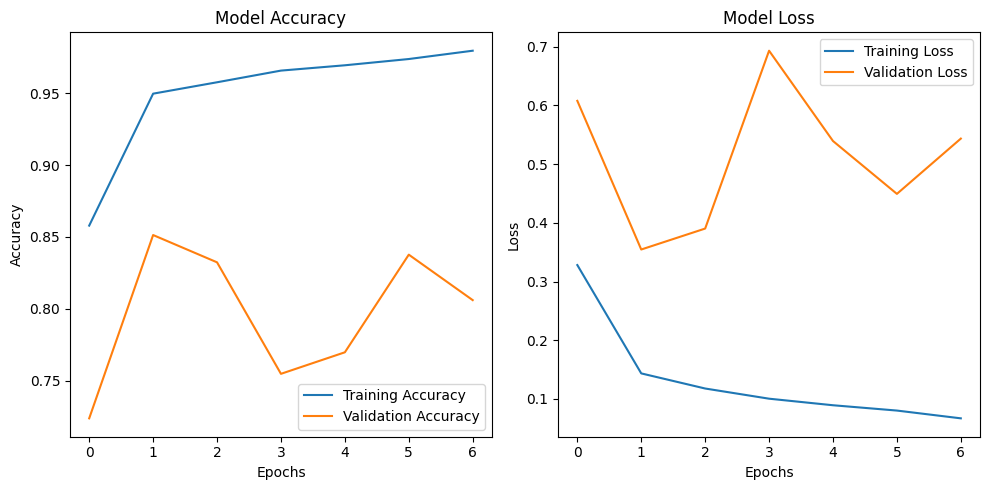

In [21]:
# Accuracy vs Loss
# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 18. Evaluate the trained model  

In [ ]:
test_loss, test_acc = model.evaluate(val_dataset)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

## 19. Make predictions with the trained model

In [ ]:
# Get the true labels
true_labels = val_dataset.classes

# Make predictions
predictions = model.predict(val_dataset)
predicted_labels = np.round(predictions).flatten()  # For binary classification

## 20. Generate F1 Score

In [ ]:
# Make predictions on the test data
y_pred_prob = predictions
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
# Calculate F1 score
print(classification_report(true_labels, y_pred, target_names=val_dataset.class_indices.keys()))
f1 = f1_score(true_labels, y_pred)
print(f'F1 Score: {f1}')

## 21. Generate the confusion matrix to validate results and plot the information

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'human'], yticklabels=['AI', 'human'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()